In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_86255/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Tau 3 Calibration (Photon Reset)

1. Play Constant Ring-Up Tone of 46.2ns
2. Play Rectangular Meas Pulse up till 270ns
2. Add a variable duration tau_3 with amp = -1.0
3. Play Qubit X Tone right after tau_3 segment and measure photons with freq spec

In [4]:
# Tau 3 Calibration Details

from helper_funcs.utils import *

tau_1 = get_dt_from(42.3 * ns) * dt
tau_2 = get_dt_from(270 * ns) * dt

tau_3_span = 33. * ns
tau_3_est = 40. * ns
num_tau_3_exp = 10
tau_3_linspace = np.linspace(-0.5 * tau_3_span + tau_3_est, 0.5 * tau_3_span + tau_3_est, num_tau_3_exp)
tau_3_linspace = convert_arr_to_dt(tau_3_linspace)
print(tau_3_linspace/ns)

qubit_tone_delay_dt = 64

freq_span = 20.0 * MHz
freq_center = -5.0 * MHz
num_freq_exp = 58
ac_freq_linspace = np.linspace(-0.5 * freq_span + freq_center, 0.5 * freq_span + freq_center, num_freq_exp)
print(ac_freq_linspace/MHz)

[24.88888889 28.44444444 32.         35.55555556 39.11111111 42.66666667
 46.22222222 49.77777778 53.33333333 56.88888889]
[-15.         -14.64912281 -14.29824561 -13.94736842 -13.59649123
 -13.24561404 -12.89473684 -12.54385965 -12.19298246 -11.84210526
 -11.49122807 -11.14035088 -10.78947368 -10.43859649 -10.0877193
  -9.73684211  -9.38596491  -9.03508772  -8.68421053  -8.33333333
  -7.98245614  -7.63157895  -7.28070175  -6.92982456  -6.57894737
  -6.22807018  -5.87719298  -5.52631579  -5.1754386   -4.8245614
  -4.47368421  -4.12280702  -3.77192982  -3.42105263  -3.07017544
  -2.71929825  -2.36842105  -2.01754386  -1.66666667  -1.31578947
  -0.96491228  -0.61403509  -0.26315789   0.0877193    0.43859649
   0.78947368   1.14035088   1.49122807   1.84210526   2.19298246
   2.54385965   2.89473684   3.24561404   3.59649123   3.94736842
   4.29824561   4.64912281   5.        ]


In [5]:
# Generate Tau_R Waveform for an input tau_3

from helper_funcs.utils import *

def generate_tau_3_waveform(tau_3):
    # First Segment: Constant Amplitude of duration meas_duration
    # # Second Segment: Gaussian Falling Edge of duration 2 * sigma
    # Third Segment: Constant Amplitude of duration tau_3

    amp = measure_pulse.amp

    total_duration_sec = tau_2 + tau_3
    linspace_len = get_closest_multiple_of_16(get_dt_from(total_duration_sec))
    ts = np.arange(linspace_len) * total_duration_sec / linspace_len

    pulse_waveform = np.heaviside(tau_1 - ts, 0.)
    pulse_waveform += amp * (np.heaviside(tau_2 - ts, 0.) - np.heaviside(tau_1 - ts, 0.))
    pulse_waveform -= 1.0 * (np.heaviside(tau_2 + tau_3 - ts, 0.) - np.heaviside(tau_2 - ts , 0.))

    # plt.plot(ts/ns, pulse_waveform)
    # plt.show()

    return pulse_waveform

waveform = generate_tau_3_waveform(tau_3=40*ns)
t_pulse = pulse.Waveform(waveform)
t_pulse.samples

array([ 1.+0.j,  1.+0.j,  1.+0.j, ..., -1.+0.j, -1.+0.j, -1.+0.j])

580
580


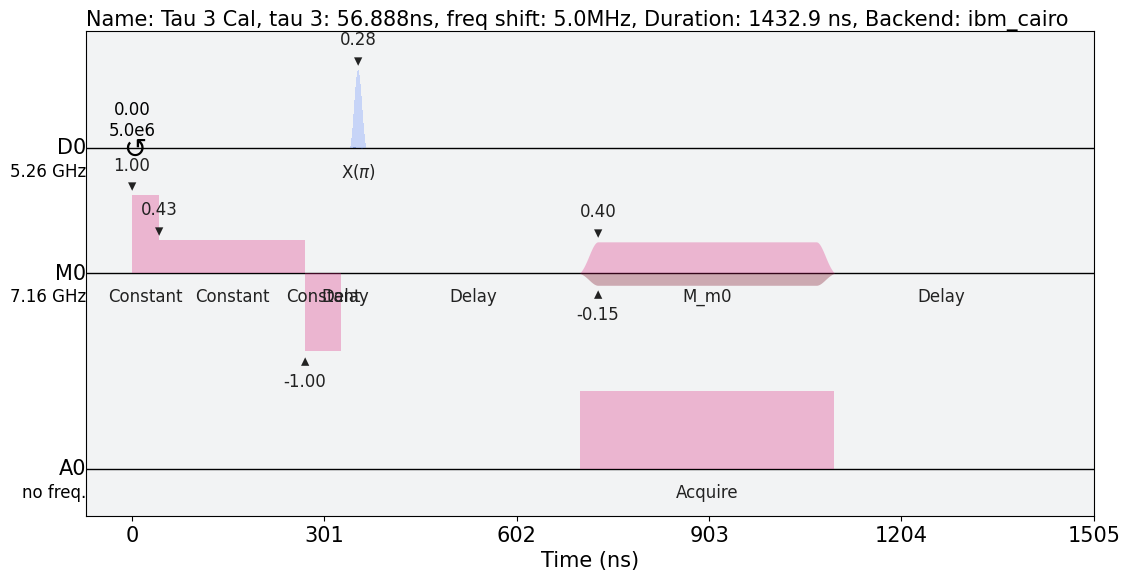

In [6]:
tau_3_exp = []
tau_3_segment_exp = []

for tau_3_sec in tau_3_linspace:
    tau_3_dt = get_closest_multiple_of_16(get_dt_from(tau_3_sec))
    tau_3_sec = tau_3_dt * dt
    tau_3_pulse = pulse.Waveform(generate_tau_3_waveform(tau_3_sec))

    for freq_shift in ac_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Tau 3 Cal, tau 3: {int(1e3*tau_3_sec / ns)/1e3}ns, freq shift: {int(1e3*freq_shift/MHz)/1e3}MHz'
        ) as tau_3_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)
            pulse.play(tau_3_pulse, meas_chan)
            pulse.delay(qubit_tone_delay_dt, meas_chan)
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        tau_3_exp.append(tau_3_sched)

        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Tau 3 Cal, tau 3: {int(1e3*tau_3_sec / ns)/1e3}ns, freq shift: {int(1e3*freq_shift/MHz)/1e3}MHz'
        ) as tau_3_segment_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_1), amp=1.0),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_2 - tau_1), amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=tau_3_dt, amp=-1.0),
                meas_chan
            )
            pulse.delay(qubit_tone_delay_dt, meas_chan)
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        tau_3_segment_exp.append(tau_3_segment_sched)

print(len(tau_3_exp))
print(len(tau_3_segment_exp))

tau_3_segment_exp[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

290


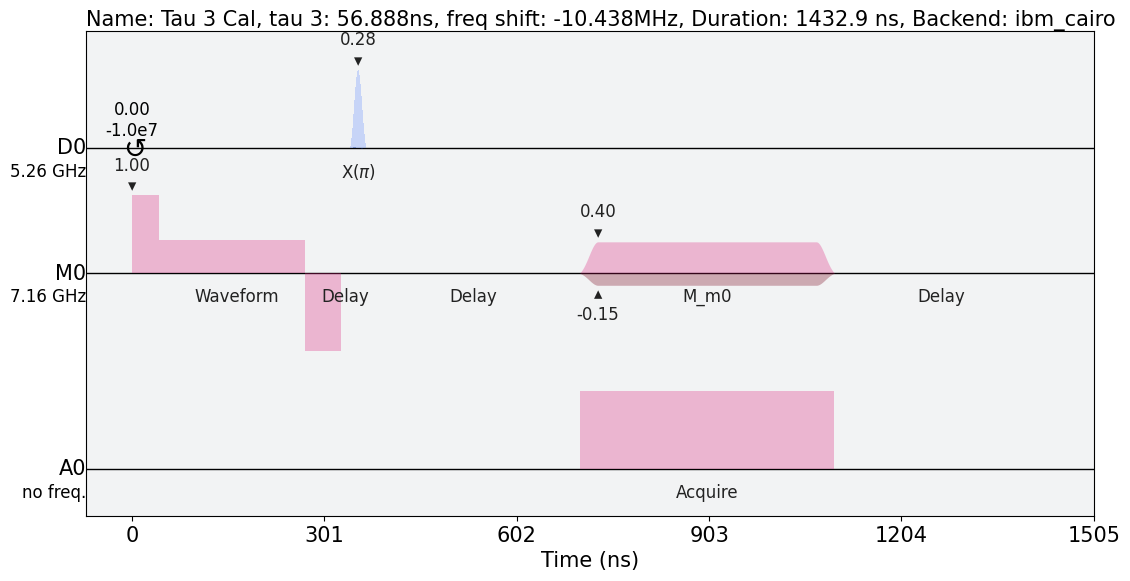

In [7]:
acquisition_checker(tau_3_exp)
acquisition_checker(tau_3_segment_exp)
exp_1, exp_2 = np.array(tau_3_exp).reshape(2, -1).tolist()
exp_3, exp_4 = np.array(tau_3_segment_exp).reshape(2, -1).tolist()

print(len(exp_1))

exp_2[-45].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [9]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

job_experiment = backend.run(exp_4, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is queued

KeyboardInterrupt: 

In [8]:
job_1 = provider.backend.retrieve_job('cpe1nkyyx18g008bhhdg')
job_2 = provider.backend.retrieve_job('cpe1nqpja3gg00811tbg')
job_3 = provider.backend.retrieve_job('cpe1nwfprheg008s0750')

In [9]:
result_1 = get_results_arr(job_1.result(), qubit)
result_2 = get_results_arr(job_2.result(), qubit)
result_3 = get_results_arr(job_3.result(), qubit)

In [ ]:
mean_1 = np.angle(np.mean(result_1, axis=-1))
mean_2 = np.angle(np.mean(result_2, axis=-1))
mean_3 = np.angle(np.mean(result_3, axis=-1))

tau_3_res = np.concatenate((mean_1, mean_2, mean_3)).reshape(num_tau_3_exp, -1)

In [12]:
tau_3_fit_res = np.zeros_like(tau_3_res)
tau_3_freqs = np.zeros(len(tau_3_fit_res))

for ind, res_obj in enumerate(tau_3_res):
    init_params = [1., -1., 10., -1.]
    params, res = fit_gaussian_with_offset(ac_freq_linspace/MHz, res_obj, init_params)
    tau_3_fit_res[ind] = res
    tau_3_freqs[ind] = params[1]

1.6074639166286475
46.222222222222214
[7.32916725 5.31402652 3.87397169 2.90753402 1.70671696 1.61363175
 1.60746392 1.75306879 2.46869973 3.55350674]


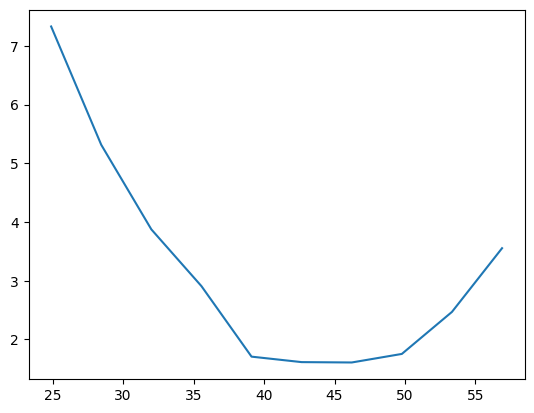

In [17]:
photons = -tau_3_freqs/0.65
print(np.min(photons))
print(tau_3_linspace[np.argmin(photons)]/ns)
print(photons)
plt.plot(tau_3_linspace/ns, photons)
plt.show()

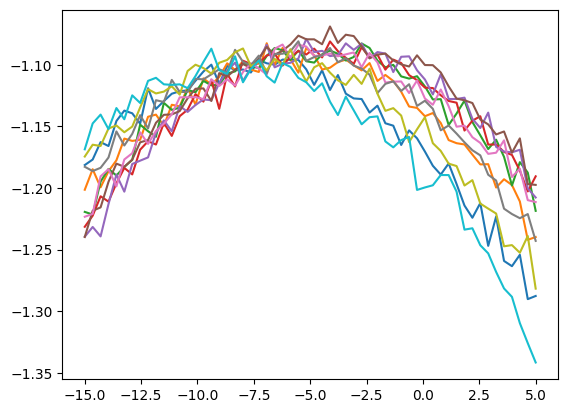

In [14]:
plt.plot(ac_freq_linspace/MHz, tau_3_res.T)

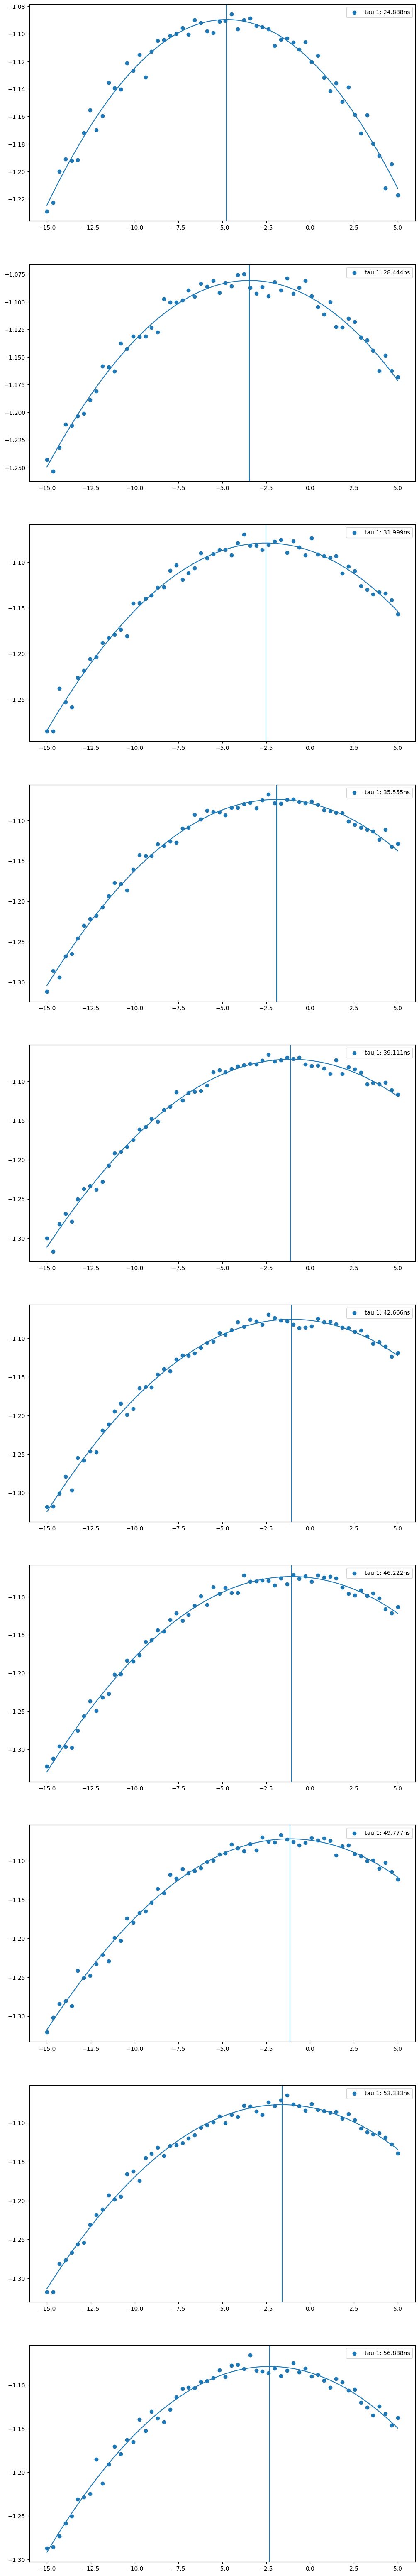

In [14]:
fig, ax = plt.subplots(num_tau_3_exp, figsize=(12.0, 80.0))

for ind, (exp_res, fit_res) in enumerate(zip(tau_3_res, tau_3_fit_res)):
    ax[ind].scatter(ac_freq_linspace/MHz, exp_res, label=f'tau 1: {int(1e3*tau_3_linspace[ind]/ns)/1e3}ns')
    ax[ind].plot(ac_freq_linspace/MHz, fit_res)
    ax[ind].axvline(x=tau_3_freqs[ind])
    ax[ind].legend()
plt.show()